#### Script to check rf and compute the visuomemory index block 1
- First, check if neuron responding to the task by comparing activity during trial vs baseline
- Second, check whether the rf is in in or out
- Third, compute the visuomemory index

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import align_trials,select_trials
from ephysvibe.task import task_constants
from ephysvibe.structures.neuron_data import NeuronData
from scipy import stats
import platform
from ephysvibe.stats import smetrics
import glob

### Def functions

In [23]:
def find_latency(p_value: np.ndarray, win: int, step: int = 1) -> np.ndarray:
    sig = np.full(p_value.shape[0], False)
    sig[p_value < 0.05] = True
    for i_step in np.arange(0, sig.shape[0], step):
        sig[i_step] = np.where(
            np.all(p_value[i_step : i_step + win] < 0.05), True, False
        )
    latency = np.where(sig)[0]

    if len(latency) != 0:
        endl = np.where(sig[latency[0] :] == False)[0]
        endl = endl[0] if len(endl) != 0 else -1
        return latency[0], endl+latency[0]+win
    else:
        return np.nan, np.nan

In [24]:
def moving_average(data: np.ndarray, win: int, step: int = 1) -> np.ndarray:
    d_shape = data.shape
    count = 0
    win = int(np.floor(win / 2))
    if len(d_shape) == 3:
        d_avg = np.zeros((d_shape[0], d_shape[1], int(np.floor(d_shape[2] / step))))
        for i_step in np.arange(0, d_shape[2] - step, step):
            st_win = 0 if i_step - win < 0 else i_step - win
            d_avg[:, :, count] = np.mean(data[:, :, st_win : i_step + win], axis=2)
            count += 1
    if len(d_shape) == 2:
        d_avg = np.zeros((d_shape[0], int(np.floor(d_shape[1] / step))))
        for i_step in np.arange(0, d_shape[1] - step, step):
            st_win = 0 if i_step - win < 0 else i_step - win
            d_avg[:, count] = np.mean(data[:, st_win : i_step + win], axis=1)
            count += 1
    if len(d_shape) == 1:
        d_avg = np.zeros((int(np.floor(d_shape[0] / step))))
        for i_step in np.arange(0, d_shape[0] - step, step):
            st_win = 0 if i_step - win < 0 else i_step - win
            d_avg[count] = np.mean(data[st_win : i_step + win], axis=0)
            count += 1
    return d_avg

In [25]:
def compute_vd_idx(
    neu_data=None,
    time_before=None,
    st_v=50, 
    end_v=200, 
    st_d=100, 
    end_d=300,
    vd_win=150,
    vd_avg_win=200,
    sp_s=None,
    sp_d=None,
    in_out=1,
):
    if neu_data is not None:
        # get spike matrices in and out conditions
        sp_s, mask_s = align_trials.get_align_tr(
            neu_data, select_block=1, select_pos=in_out, time_before=time_before+vd_avg_win
        )
        sp_s = sp_s[neu_data.sample_id[mask_s] != 0]
        sp_d, mask_d = align_trials.get_align_tr(
            neu_data,
            select_block=1,
            select_pos=in_out,
            time_before=0+vd_avg_win,
            event="sample_off",
        )
        sp_d = sp_d[neu_data.sample_id[mask_d] != 0]

        sp_s = moving_average(data=sp_s, win=vd_avg_win, step=1)[:,vd_avg_win:]
        sp_d = moving_average(data=sp_d, win=vd_avg_win, step=1)[:,vd_avg_win:]

    #### Compute VD index
    # get avg fr over trials and time
    vd_idx, bl_mean, g1_mean, g2_mean = np.nan, np.nan, np.nan, np.nan

    
    if np.logical_and(sp_d.shape[0] > 2, sp_d.ndim > 1):
        vd_idx, bl_mean, g1_mean, g2_mean = get_vd_index(
            bl=sp_s[:, :time_before],
            group1=sp_s[:, time_before : time_before + st_v + 460],
            group2=sp_d[:, :st_d+460],
            st_v=st_v,
            end_v=end_v,
            st_d=st_d,
            end_d=end_d,
            pwin=vd_win,
        )

    return vd_idx, bl_mean, g1_mean, g2_mean


In [26]:
plt.close()

In [27]:
def get_vd_index(bl, group1, group2, st_v, end_v, st_d, end_d, pwin=75):
    p_son, p_d = [], []
    bl = np.mean(bl, axis=1)
    for i in range(st_v, end_v):
        g1 = group1[:, i]
        p_son.append(stats.ranksums(bl, g1)[1])
    for i in range(st_d, end_d):
        g2 = group2[:, i]
        p_d.append(stats.ranksums(bl, g2)[1])
    p_son = np.array(p_son)
    p_d = np.array(p_d)
    lat_son, end_son = find_latency(p_value=p_son, win=pwin, step=1)
    lat_don, end_don = find_latency(p_value=p_d, win=pwin, step=1)
    if np.logical_and(np.isnan(lat_son), np.isnan(lat_don)):
        return np.nan, np.nan, np.nan, np.nan
    else:
        g1 = group1[:, st_v:end_v]
        g2 = group2[:, st_d:end_d]
    bl_mean = np.mean(bl)
    g1_mean = np.mean(g1)
    g2_mean = np.mean(g2)
    g2_mean_bl = np.abs(g2_mean - bl_mean)
    g1_mean_bl = np.abs(g1_mean - bl_mean)
    # if np.logical_and(g1_mean_bl*1000<3,g2_mean_bl*1000<3):
    #     return np.nan, np.nan, np.nan, np.nan
    vd_idx = (g2_mean_bl - g1_mean_bl) / (g1_mean_bl + g2_mean_bl)

    if np.logical_and(np.isnan(lat_son), vd_idx < 0):
        return np.nan, np.nan, np.nan, np.nan
    elif np.logical_and(np.isnan(lat_don), vd_idx > 0):
        return np.nan, np.nan, np.nan, np.nan
    else:
        return vd_idx, bl_mean * 1000, g1_mean * 1000, g2_mean * 1000

In [28]:
def get_align_tr(neu_data, select_block, select_pos, time_before, event="sample_on"):
    sp, mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block=select_block,
        select_pos=select_pos,
        event=event,
        time_before=time_before,
        error_type=0,
    )
    return sp, mask

In [29]:
def plot_raster_conv(sp_sample, start, conv, time, ax1, ax2, colors):
    n_trials = 0
    for key, sp in sp_sample.items():
        # ----- plot conv----------
        ax1.plot(time, conv[key], color=colors[key])
        # ----- plot spikes----------
        rows, cols = np.where(sp >= 1)
        ax2.scatter(
            cols + start,
            rows + n_trials,
            marker="|",
            alpha=1,
            edgecolors="none",
            color=colors[key],
            label="sample %s" % key,
        )
        n_trials = n_trials + sp.shape[0]

    return ax1, ax2, n_trials

In [30]:
def plot_raster_vd(neu_data,vd_in,vd_out):
    # parameters
    time_before = 500
    select_block = 1
    start = -200
    end = 1200
    idx_start = time_before + start
    idx_end = time_before + end
    # ---------------
    conv_all = {"in": {}, "out": {}}
    all_sp_by_sample = {"in": {}, "out": {}}
    pos_label = ["in", "out"]
    pos_code = [1, -1]
    count_trials = 0
    all_max_conv = 0
    all_max_trial = 0
    for code, pos in zip(pos_code, pos_label):
        # select correct trials, block one, inside/outside RF, and align with sample onset
        sp_sample_on, mask = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block=select_block,
            select_pos=code,
            event="sample_on",
            time_before=time_before,
            error_type=0,
        )

        sample_id = neu_data.sample_id[mask]
        sp_by_sample = select_trials.get_sp_by_sample(sp_sample_on, sample_id)
        for key, value in sp_by_sample.items():
            arr = value.mean(axis=0)
            conv = firing_rate.convolve_signal(
                arr=arr, fs=1000, w_size=0.1, w_std=0.015, axis=0
            )[idx_start:idx_end]
            conv_all[pos][key] = conv
            sp_by_sample[key] = value[:, idx_start:idx_end]
            count_trials = value.shape[0]
            max_conv = np.max(conv)
            all_max_conv = max_conv if max_conv > all_max_conv else all_max_conv
            all_max_trial = (
                count_trials if count_trials > all_max_trial else all_max_trial
            )
        all_sp_by_sample[pos] = sp_by_sample

    fig, (ax_in, ax_out) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), sharey=True)

    time = np.arange(0, end - start) + start
    ax_in_2 = ax_in.twinx()
    pos = "in"
    ax_in, ax_in_2, n_trials_in = plot_raster_conv(
        all_sp_by_sample[pos],
        start,
        conv_all[pos],
        time,
        ax_in,
        ax_in_2,
        colors=task_constants.PALETTE_B1,
    )
    ax_out_2 = ax_out.twinx()
    pos = "out"
    ax_out, ax_out_2, n_trials_out = plot_raster_conv(
        all_sp_by_sample[pos],
        start,
        conv_all[pos],
        time,
        ax_out,
        ax_out_2,
        colors=task_constants.PALETTE_B1,
    )

    all_max_trial = max([n_trials_in, n_trials_out])
    # -----parameters in plot
    ax_in_2.axes.set_yticks(np.arange(-all_max_conv - 5, all_max_trial))
    ax_in.axes.set_ylim(0, all_max_conv + all_max_trial + 5)
    ax_in.axes.set_yticks(np.arange(0, all_max_conv + 5, 10))
    plt.setp(ax_in_2.axes.get_yticklabels(), visible=False)
    plt.setp(ax_in_2.axes.get_yaxis(), visible=False)
    ax_in.set_title("in - vd idx: %f"%vd_in, fontsize=15)
    ax_in.vlines(
        [0, 450, 900],
        0,
        all_max_conv + all_max_trial + 5,
        color="k",
        linestyles="dashed",
    )
    ax_in.spines["right"].set_visible(False)
    ax_in.spines["top"].set_visible(False)
    ax_in_2.spines["right"].set_visible(False)
    ax_in_2.spines["top"].set_visible(False)
    ax_in.set_xlabel(xlabel="Time (ms)", fontsize=18)
    ax_in.set_ylabel(ylabel="Average firing rate", fontsize=15, loc="bottom")
    for xtick in ax_in.xaxis.get_major_ticks():
        xtick.label1.set_fontsize(15)
    for ytick in ax_in.yaxis.get_major_ticks():
        ytick.label1.set_fontsize(15)
    for xtick in ax_in_2.xaxis.get_major_ticks():
        xtick.label1.set_fontsize(15)
    # -----parameters out plot
    ax_out_2.axes.set_yticks(np.arange(-all_max_conv - 5, all_max_trial))
    ax_out.axes.set_ylim(0, all_max_conv + all_max_trial + 5)
    ax_out.axes.set_yticks(np.arange(0, all_max_conv + 5, 10))
    plt.setp(ax_out_2.axes.get_yticklabels(), visible=False)
    plt.setp(ax_out_2.axes.get_yaxis(), visible=False)
    ax_out.set_title("out - vd idx: %f"%vd_out, fontsize=15)
    ax_out.vlines(
        [0, 450, 900],
        0,
        all_max_conv + all_max_trial + 5,
        color="k",
        linestyles="dashed",
    )
    ax_out.spines["right"].set_visible(False)
    ax_out.spines["top"].set_visible(False)
    ax_out_2.spines["right"].set_visible(False)
    ax_out_2.spines["top"].set_visible(False)
    ax_out.set_xlabel(xlabel="Time (ms)", fontsize=18)
    for xtick in ax_out.xaxis.get_major_ticks():
        xtick.label1.set_fontsize(15)
    for ytick in ax_out.yaxis.get_major_ticks():
        ytick.label1.set_fontsize(15)
    for xtick in ax_out_2.xaxis.get_major_ticks():
        xtick.label1.set_fontsize(15)
    ax_out_2.legend(
        fontsize=15, scatterpoints=5, columnspacing=0.5, framealpha=0, loc="upper right"
    )
    ## --- figure
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)
    fig.suptitle(
        "%s: %s %s %d "
        % (
            neu_data.date_time,
            neu_data.area,
            neu_data.cluster_group,
            neu_data.cluster_number,
        ),
        x=0.05,
        y=0.99,
        fontsize=15,
    )

### Start analysis

In [31]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'D:/data/'#'C:/Users/camil/Documents/int/'
#basepath = '//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'

#### Select parameters

In [32]:
time_before = 200
time_before = 500
start = -200
end = 1000
mov_avg_win = 100
selec_win = 75

vd_win = 75
vd_avg_win = 100
area='v4'
st_v=50 
end_v=200 
st_d=100 
end_d=300

In [33]:
neu_path = basepath + "session_struct/" + area + "/neurons/*neu.h5"
path_list = glob.glob(neu_path)

In [34]:
plt.close()

In [35]:
path_list

['D:/data/session_struct/v4/neurons\\2022-12-02_11-01-23_Riesling_v4_e1_r1_mua50_neu.h5',
 'D:/data/session_struct/v4/neurons\\2022-12-02_11-01-23_Riesling_v4_e1_r1_mua51_neu.h5',
 'D:/data/session_struct/v4/neurons\\2022-12-02_11-01-23_Riesling_v4_e1_r1_mua52_neu.h5',
 'D:/data/session_struct/v4/neurons\\2022-12-02_11-01-23_Riesling_v4_e1_r1_mua53_neu.h5',
 'D:/data/session_struct/v4/neurons\\2022-12-02_11-01-23_Riesling_v4_e1_r1_mua54_neu.h5',
 'D:/data/session_struct/v4/neurons\\2022-12-02_11-01-23_Riesling_v4_e1_r1_mua55_neu.h5',
 'D:/data/session_struct/v4/neurons\\2022-12-02_11-01-23_Riesling_v4_e1_r1_good15_neu.h5',
 'D:/data/session_struct/v4/neurons\\2022-12-06_11-12-04_Riesling_v4_e1_r1_mua3_neu.h5',
 'D:/data/session_struct/v4/neurons\\2022-12-06_11-12-04_Riesling_v4_e1_r1_good1_neu.h5',
 'D:/data/session_struct/v4/neurons\\2022-12-06_11-12-04_Riesling_v4_e1_r1_mua4_neu.h5',
 'D:/data/session_struct/v4/neurons\\2022-12-06_11-12-04_Riesling_v4_e1_r1_mua5_neu.h5',
 'D:/data/se

D:/data/session_struct/v4/neurons\2022-12-05_10-51-52_Riesling_v4_e1_r1_good12_neu.h5


C:\Users\camil\AppData\Local\Temp\ipykernel_28076\2292913546.py:8: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(


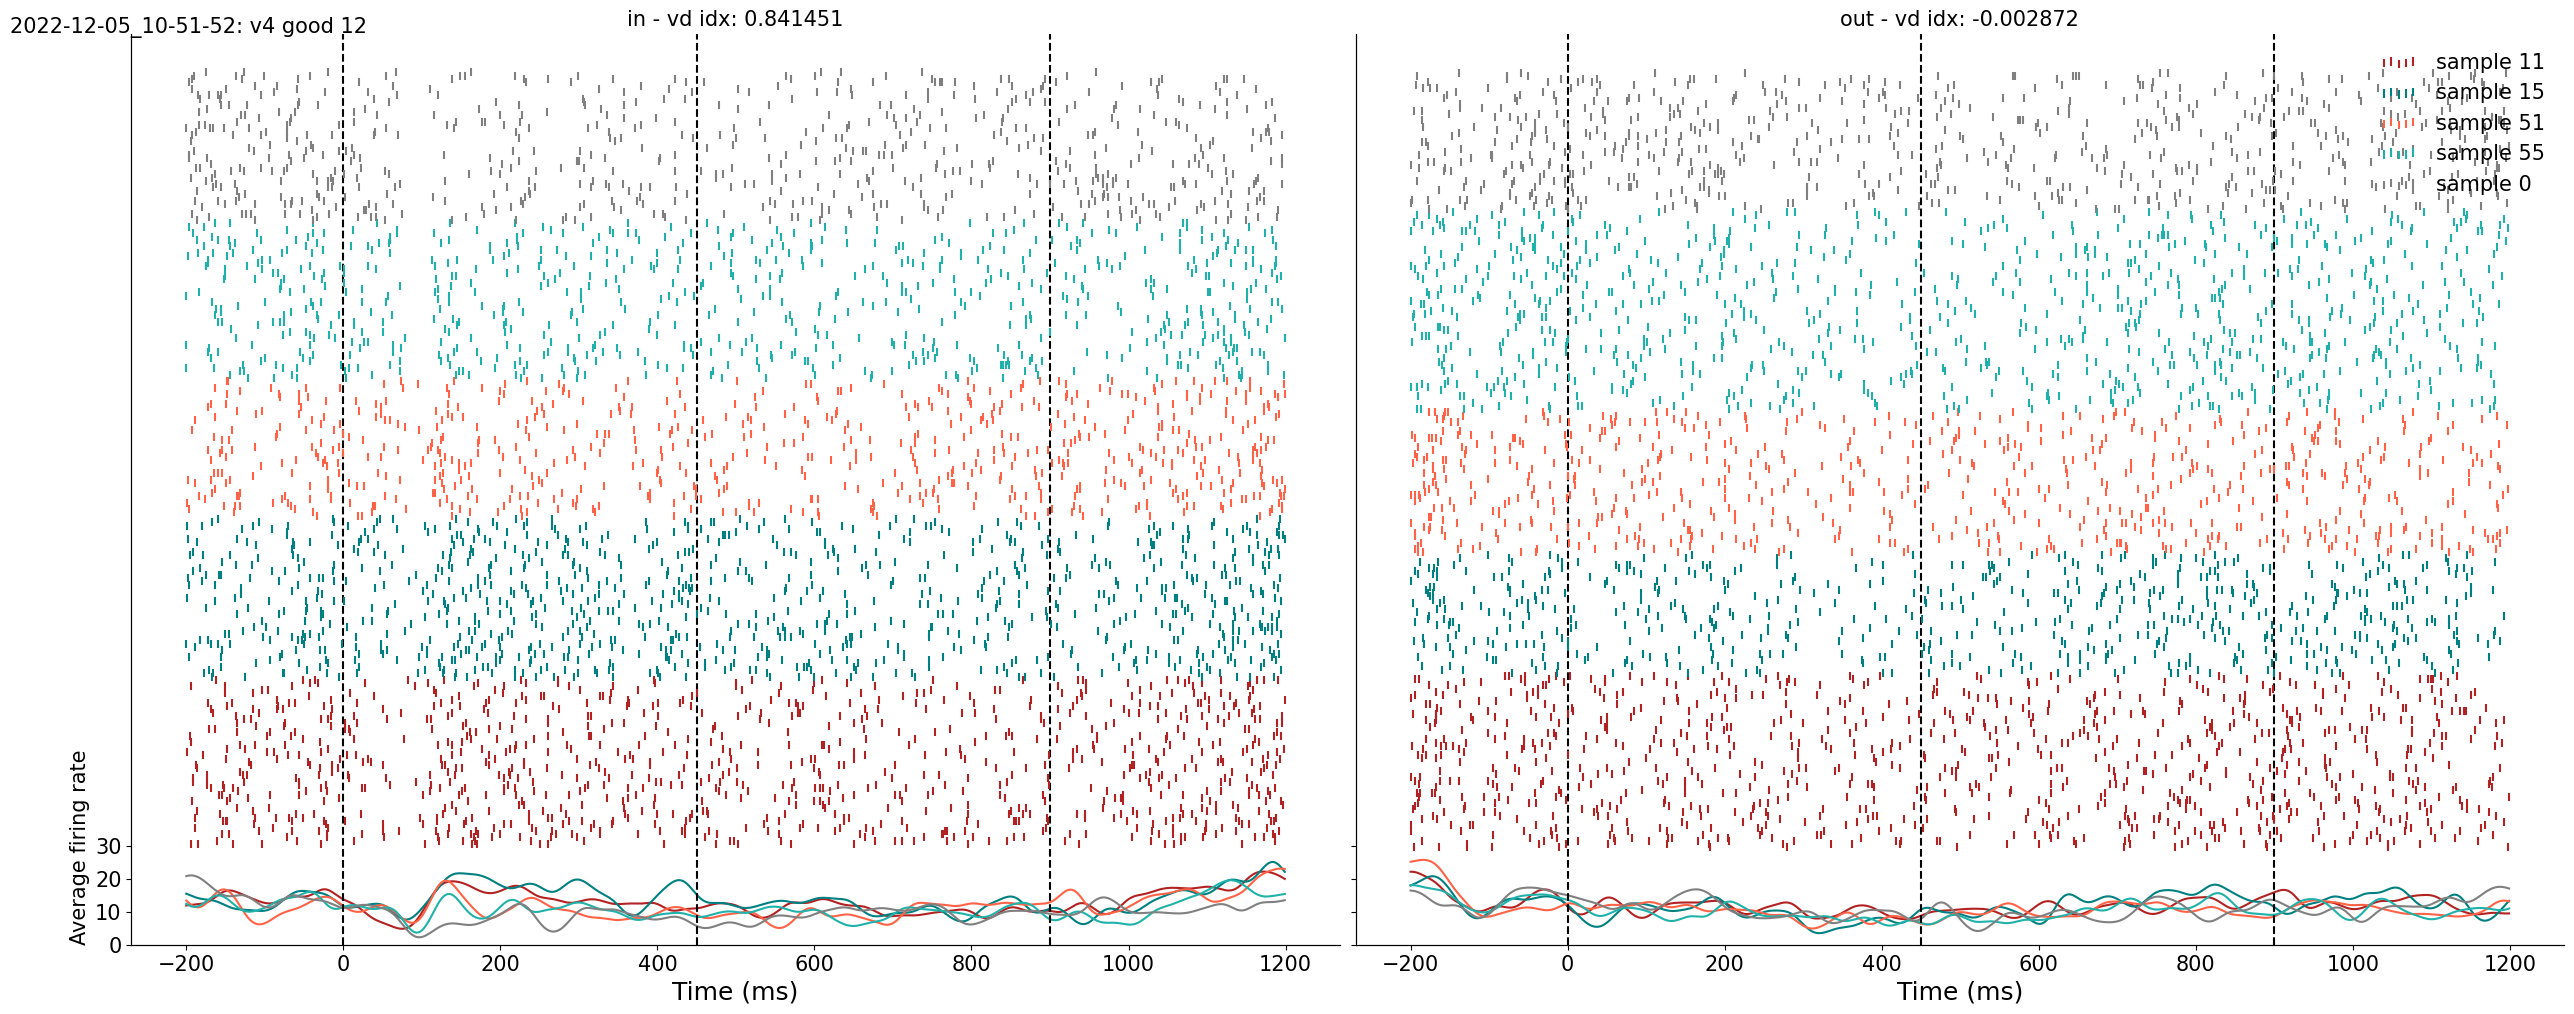

In [38]:
for neu_path in [ 'D:/data/session_struct/v4/neurons\\2022-12-05_10-51-52_Riesling_v4_e1_r1_good12_neu.h5']:#path_list[2:30]:
    
    neu_data = NeuronData.from_python_hdf5(neu_path)

    # get spike matrices in and out conditions
    sp_in, mask_in = get_align_tr(
        neu_data, select_block=1, select_pos=1, time_before=time_before
    )
    sp_in = sp_in[neu_data.sample_id[mask_in] != 0]
    sp_out, mask_out = get_align_tr(
        neu_data, select_block=1, select_pos=-1, time_before=time_before
    )
    sp_out = sp_out[neu_data.sample_id[mask_out] != 0]
    sp_din, mask_din = get_align_tr(
        neu_data, select_block=1, select_pos=1, time_before=0, event="sample_off"
    )
    sp_din = sp_din[neu_data.sample_id[mask_din] != 0]
    sp_dout, mask_dout = get_align_tr(
        neu_data, select_block=1, select_pos=-1, time_before=0, event="sample_off"
    )
    sp_dout = sp_dout[neu_data.sample_id[mask_dout] != 0]

    #### Compute VD index
    # get avg fr over trials and time
    vd_in, bl_in, g1_in, g2_in = np.nan, np.nan, np.nan, np.nan
    vd_out, bl_out, g1_out, g2_out = np.nan, np.nan, np.nan, np.nan

    print(neu_path)
    if np.logical_and(sp_din.shape[0] > 2, sp_din.ndim > 1):
        vd_in, bl_in, g1_in, g2_in = compute_vd_idx(
            neu_data=neu_data,
            time_before=abs(start),
            st_v=st_v, 
            end_v=end_v, 
            st_d=st_d, 
            end_d=end_d,
            vd_win=vd_win,
            vd_avg_win=vd_avg_win,
            in_out=1,
        )
    if np.logical_and(sp_dout.shape[0] > 2, sp_dout.ndim > 1):
        vd_out, bl_out, g1_out, g2_out = compute_vd_idx(
            neu_data=neu_data,
            time_before=abs(start),
            st_v=st_v, 
            end_v=end_v, 
            st_d=st_d, 
            end_d=end_d,
            vd_win=vd_win,
            vd_avg_win=vd_avg_win,
            in_out=-1,
        )
    plot_raster_vd(neu_data,vd_in,vd_out)

#### Compute VD index